In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [2]:
print(tf.__version__)

1.12.0


# Load the Reuters dataset

In [3]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# Data analysis

In [4]:
x = train_data
print("Training Data:", len(x.shape), 'D Tensor,', x.shape[0], 'samples,', x.dtype, 'data type.')
x = train_labels
print("Training Labels:", len(x.shape), 'D Tensor,', x.shape[0], 'samples,', x.dtype, 'data type.')
x = test_data
print("Test Data:", len(x.shape), 'D Tensor,', x.shape[0], 'samples,', x.dtype, 'data type.')
x = test_labels
print("Test Labels:", len(x.shape), 'D Tensor,', x.shape[0], 'samples,', x.dtype, 'data type.')

Training Data: 1 D Tensor, 8982 samples, object data type.
Training Labels: 1 D Tensor, 8982 samples, int64 data type.
Test Data: 1 D Tensor, 2246 samples, object data type.
Test Labels: 1 D Tensor, 2246 samples, int64 data type.


In [5]:
print(train_data[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [6]:
print(train_labels[0])

3


In [7]:
len(train_data[0]), len(train_data[1])

(87, 56)

In [8]:
# num_words=10000 => no word index will exceed 10000
max([max(sequence) for sequence in train_data])

9999

In [9]:
max([min(sequence) for sequence in train_data])

1

In [10]:
# Decode one review
word_index = reuters.get_word_index()
reverse_word_index = dict(
    [(value,key) for (key, value) in word_index.items()])
decoded_review = ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print(decoded_review)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


# Preparing the data

In [11]:
# Encoding the integer sequences into a binary matrix
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
# Vectorized training and test data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [12]:
#  One-hot encoding is a format for categorical data, also called categorical encoding
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Vectorized training using a function
one_hot_train_labels = to_one_hot(train_labels)
# Or vectorized labels using what is built-in in Keras
one_hot_test_labels = to_categorical(test_labels)

In [13]:
# another way to encode the labels would be to cast them as an integer tensor
# With integer labels, use sparse_categorical_crossentropy loss at model.compile
y_train_cast = np.array(train_labels)
y_test_cast = np.array(test_labels)

In [14]:
x = x_train
print("Train Data:", len(x.shape), 'D Tensor,', x.shape[0], 'samples,', x.dtype, 'data type.')
x = x_test
print("Test Data:", len(x.shape), 'D Tensor,', x.shape[0], 'samples,', x.dtype, 'data type.')
x = one_hot_train_labels
print("Train Labels:", len(x.shape), 'D Tensor,', x.shape[0], 'samples,', x.dtype, 'data type.')
x = one_hot_test_labels
print("Test Labels:", len(x.shape), 'D Tensor,', x.shape[0], 'samples,', x.dtype, 'data type.')
x = y_train_cast
print("Integer Train Labels:", len(x.shape), 'D Tensor,', x.shape[0], 'samples,', x.dtype, 'data type.')
x = y_test_cast
print("Integer Test Labels:", len(x.shape), 'D Tensor,', x.shape[0], 'samples,', x.dtype, 'data type.')

Train Data: 2 D Tensor, 8982 samples, float64 data type.
Test Data: 2 D Tensor, 2246 samples, float64 data type.
Train Labels: 2 D Tensor, 8982 samples, float64 data type.
Test Labels: 2 D Tensor, 2246 samples, float32 data type.
Integer Train Labels: 1 D Tensor, 8982 samples, int64 data type.
Integer Test Labels: 1 D Tensor, 2246 samples, int64 data type.


In [15]:
print(x_train)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]


In [16]:
print(one_hot_train_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
print(y_train_cast)

[ 3  4  3 ... 25  3 25]


# Build the model

In a stack of Dense layers like that you’ve been using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an information bottleneck. In the previous example, you used 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information.
The last layer uses a softmax activation, it means that the network will output a probability distribution over the 46 different output classes—for every input sample, the network will produce a 46-dimensional output vector, where output[i] is the probability that the sample belongs to class i. The 46 scores will sum to 1.

In [18]:
model = models.Sequential()
model.add(layers.Dense(64, activation= tf.nn.relu, input_shape=(10000,)))
model.add(layers.Dense(64, activation=tf.nn.relu))
model.add(layers.Dense(46, activation=tf.nn.softmax))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


# Model compilation

In [19]:
model.compile(optimizer='rmsprop',
              loss=losses.categorical_crossentropy,
              # with integer labels, use sparse_categorical_crossentropy
              metrics=[metrics.categorical_accuracy])

# Create a validation set

In [20]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

# Train the model

In [21]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=9,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 113us/step - loss: 2.6340 - categorical_accuracy: 0.5492 - val_loss: 1.7448 - val_categorical_accuracy: 0.6430
Epoch 2/9
7982/7982 [==============================] - 1s 87us/step - loss: 1.4286 - categorical_accuracy: 0.7036 - val_loss: 1.3058 - val_categorical_accuracy: 0.7020
Epoch 3/9
7982/7982 [==============================] - 1s 77us/step - loss: 1.0542 - categorical_accuracy: 0.7746 - val_loss: 1.1167 - val_categorical_accuracy: 0.7720
Epoch 4/9
7982/7982 [==============================] - 1s 78us/step - loss: 0.8190 - categorical_accuracy: 0.8311 - val_loss: 1.0097 - val_categorical_accuracy: 0.7950
Epoch 5/9
7982/7982 [==============================] - 1s 73us/step - loss: 0.6422 - categorical_accuracy: 0.8698 - val_loss: 0.9532 - val_categorical_accuracy: 0.8020
Epoch 6/9
7982/7982 [==============================] - 1s 78us/step - loss: 0.5155 - categorical_accuracy: 0.89

# Training logs

In [22]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


# Plotting the training and validation loss

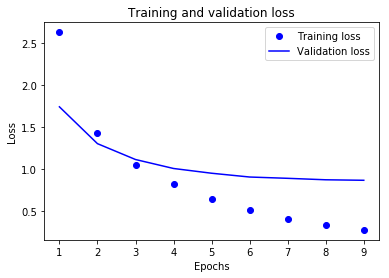

In [23]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['loss']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy

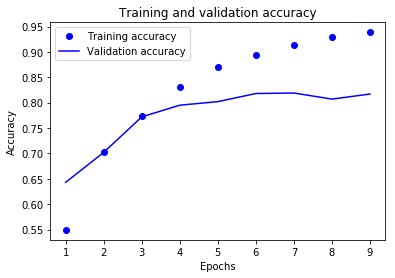

In [24]:
acc_values = history_dict['categorical_accuracy']
val_acc_values = history_dict['val_categorical_accuracy']

plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model

In [25]:
result = model.evaluate(x_test, one_hot_test_labels)
print(model.metrics_names)
print(result)

2246/2246 [==============================] - 0s 80us/step
['loss', 'categorical_accuracy']
[0.9827541319897211, 0.7889581478714199]


# Generate predictions on new data

In [26]:
# random clasification
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.1803205699020481

In [27]:
predictions = model.predict(x_test)

In [28]:
predictions[0].shape

(46,)

In [29]:
np.sum(predictions[0])

1.0

In [30]:
np.argmax(predictions[0])

3

In [31]:
predictions[0]

array([1.2262804e-03, 2.8962345e-04, 1.6816919e-05, 9.0167129e-01,
       7.5233296e-02, 1.4783153e-06, 1.2209399e-04, 3.0792540e-05,
       6.0340902e-04, 4.2182364e-05, 8.3789823e-04, 8.3931501e-04,
       1.9801867e-03, 1.3421466e-04, 1.9806720e-04, 5.4893089e-06,
       9.0655917e-04, 2.4896723e-04, 3.3274235e-05, 2.0483851e-03,
       3.6425635e-03, 3.7375335e-03, 4.4536162e-05, 6.3084083e-04,
       5.4150182e-06, 1.6224045e-04, 7.8841267e-06, 1.0121739e-05,
       1.5700175e-04, 1.0898976e-03, 9.9662946e-05, 5.1329273e-04,
       2.7371696e-04, 7.7888675e-05, 5.0099006e-05, 1.3718796e-04,
       7.3350314e-04, 4.4572409e-04, 5.4385793e-05, 1.3548512e-03,
       8.9380657e-05, 7.8581506e-05, 3.2114436e-05, 2.6936737e-05,
       7.1224873e-05, 3.7857469e-06], dtype=float32)

# Experiments

- layer 2 with 4 hidden units: => Information bottleneck
    - validation before:
    - ['loss', 'categorical_accuracy']
    - [0.9778324326339409, 0.7960819234459504]
    - validation before:
    - ['loss', 'categorical_accuracy']
    - [1.4548913428322714, 0.6629563668744435]
- layer 2 with 32 hidden units: => still some Information bottleneck
    - validation before:
    - ['loss', 'categorical_accuracy']
    - [0.9778324326339409, 0.7960819234459504]
    - validation before: 
    - ['loss', 'categorical_accuracy']
    - [1.0003085945295842, 0.7804986642920748]
- layer 2 with 128 hidden units: => to complex, small impact
    - validation before:
    - ['loss', 'categorical_accuracy']
    - [0.9778324326339409, 0.7960819234459504]
    - validation before:
    - ['loss', 'categorical_accuracy']
    - [0.9832570516734068, 0.7943009795456832]
- one hidden layer: => same accuracy
    - validation before:
    - ['loss', 'categorical_accuracy']
    - [0.9778324326339409, 0.7960819234459504]
    - validation before: 
    - ['loss', 'categorical_accuracy']
    - [0.9094284931040192, 0.8005342832231565]
- three hidden layer: => drop in accuracy
    - validation before:
    - ['loss', 'categorical_accuracy']
    - [0.9778324326339409, 0.7960819234459504]
    - validation before:
    - ['loss', 'categorical_accuracy']
    - [1.114083481599259, 0.7778272483885978]
